## load data from Kaggle

<a href='https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/'>How to Load Kaggle Datasets Directly into Google Colab?</a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

100% 712M/714M [00:08<00:00, 87.9MB/s]
100% 714M/714M [00:08<00:00, 92.0MB/s]


In [ ]:
! unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
import glob
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as T
import albumentations as A

from collections import OrderedDict, defaultdict 
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import prewitt, prewitt_h, prewitt_v, threshold_local

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ROOT_PATH = '../content/kaggle_3m/'

In [ ]:
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
mask_files[:5]

['../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44_mask.tif',
 '../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_30_mask.tif',
 '../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_2_mask.tif',
 '../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_35_mask.tif',
 '../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_27_mask.tif']

In [ ]:
image_files = [file.replace('_mask', '') for file in mask_files]
image_files[:5]

['../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_44.tif',
 '../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_30.tif',
 '../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_2.tif',
 '../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_35.tif',
 '../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_27.tif']

In [ ]:
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})
df.head()

image_path  \
0  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...   
1  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...   
2  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...   
3  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...   
4  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...   

                                           mask_path  diagnosis  
0  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...          1  
1  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...          0  
2  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...          0  
3  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...          0  
4  ../content/kaggle_3m/TCGA_DU_A5TT_19980318/TCG...          0

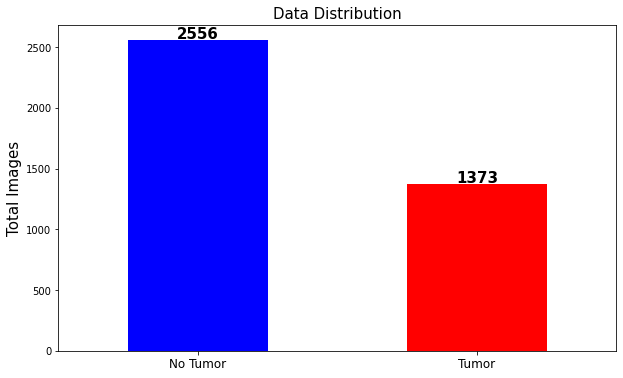

In [ ]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

In [ ]:
train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15)
train_df = train_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


## Visualize Image with Mask

In [ ]:
IMG_SIZE = 521
images = []
masks = []
df_positive = df[df['diagnosis']==1].sample(5).values

In [ ]:
for data in df_positive:
    img = cv2.resize(cv2.imread(data[0]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    images.append(img)
    masks.append(mask)

In [ ]:
len(images)

5

In [ ]:
images[0].shape

(521, 521, 3)

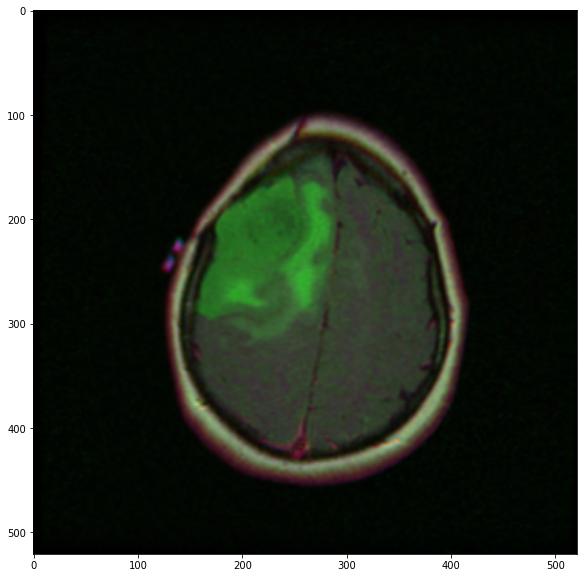

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(images[0])

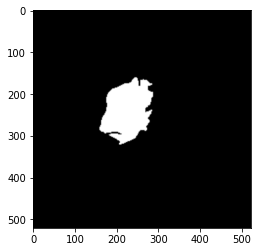

In [ ]:
plt.imshow(masks[0])

In [ ]:
gamma_images = list(map(lambda image: (np.array(255*rgb2gray(image) ** 1.3, dtype='uint8')),[image for image in images]))

In [ ]:
gamma_images[0].shape

(521, 521)

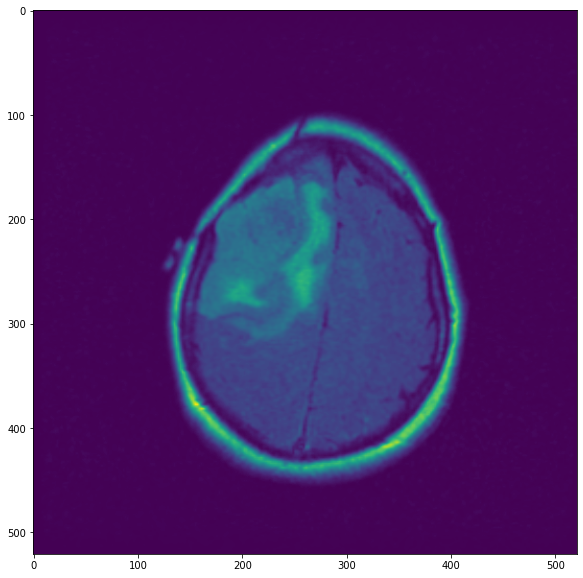

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(gamma_images[0])

In [ ]:
hist_eq_images = list(map(lambda image: exposure.equalize_hist(255*rgb2gray(image)),[image for image in images]))

In [ ]:
gray_images = list(map(lambda image: rgb2gray(image),[image for image in images]))

In [ ]:
gray_images[0].shape

(521, 521)

In [ ]:
hist_eq_images[0].shape

(521, 521)

In [ ]:
prewitt_images = list(map(lambda image: prewitt(rgb2gray(image)),[image for image in images]))

In [ ]:
prewitt_h_images = list(map(lambda image: prewitt_h(rgb2gray(image)),[image for image in images]))

In [ ]:
prewitt_v_images = list(map(lambda image: prewitt_v(rgb2gray(image)),[image for image in images]))

In [ ]:
local_segments_images = list(map(lambda image: threshold_local(rgb2gray(image), 15, 'mean'),[image for image in images]))

In [ ]:
prewitt_images[0].shape

(521, 521)

In [ ]:
np.array(images).shape

(5, 521, 521, 3)

In [ ]:
np.array(gamma_images).shape

(5, 521, 521)

In [ ]:
np.array(gray_images).shape

(5, 521, 521)

In [ ]:
gamma_images = np.array([gamma_images]).transpose(1,2,3,0)
gamma_images.shape

(5, 521, 521, 1)

In [ ]:
prewitt_images = np.array([prewitt_images]).transpose(1,2,3,0)
prewitt_images.shape

(5, 521, 521, 1)

In [ ]:
prewitt_h_images = np.array([prewitt_h_images]).transpose(1,2,3,0)
prewitt_h_images.shape

(5, 521, 521, 1)

In [ ]:
prewitt_v_images = np.array([prewitt_v_images]).transpose(1,2,3,0)
prewitt_v_images.shape

(5, 521, 521, 1)

In [ ]:
local_segments_images = np.array([local_segments_images]).transpose(1,2,3,0)
local_segments_images.shape

(5, 521, 521, 1)

In [ ]:
hist_eq_images = np.array([hist_eq_images]).transpose(1,2,3,0)
hist_eq_images.shape

(5, 521, 521, 1)

In [ ]:
gray_images = np.array([gray_images]).transpose(1,2,3,0)
gray_images.shape

(5, 521, 521, 1)

In [ ]:
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))
gamma_images = np.hstack(gamma_images)
hist_eq_images = np.hstack(hist_eq_images)
gray_images = np.hstack(gray_images)
prewitt_images = np.hstack(prewitt_images)
prewitt_h_images = np.hstack(prewitt_h_images)
prewitt_v_images = np.hstack(prewitt_v_images)
local_segments_images = np.hstack(local_segments_images)

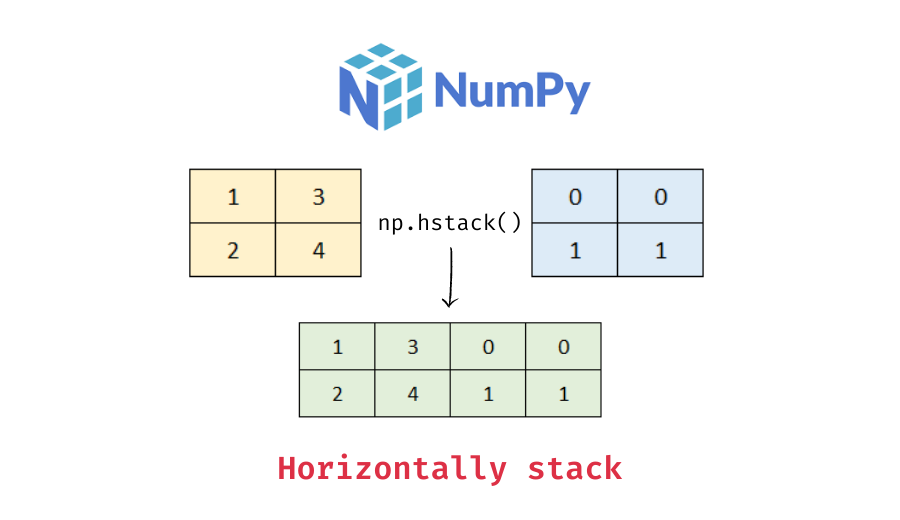

In [ ]:
images.shape

(521, 2605, 3)

In [ ]:
masks.shape

(521, 2605, 3)

In [ ]:
gamma_images.shape

(521, 2605, 1)

In [ ]:
hist_eq_images.shape

(521, 2605, 1)

In [ ]:
gray_images.shape

(521, 2605, 1)

In [ ]:
prewitt_images.shape

(521, 2605, 1)

In [ ]:
prewitt_h_images.shape

(521, 2605, 1)

IndexError: ignored

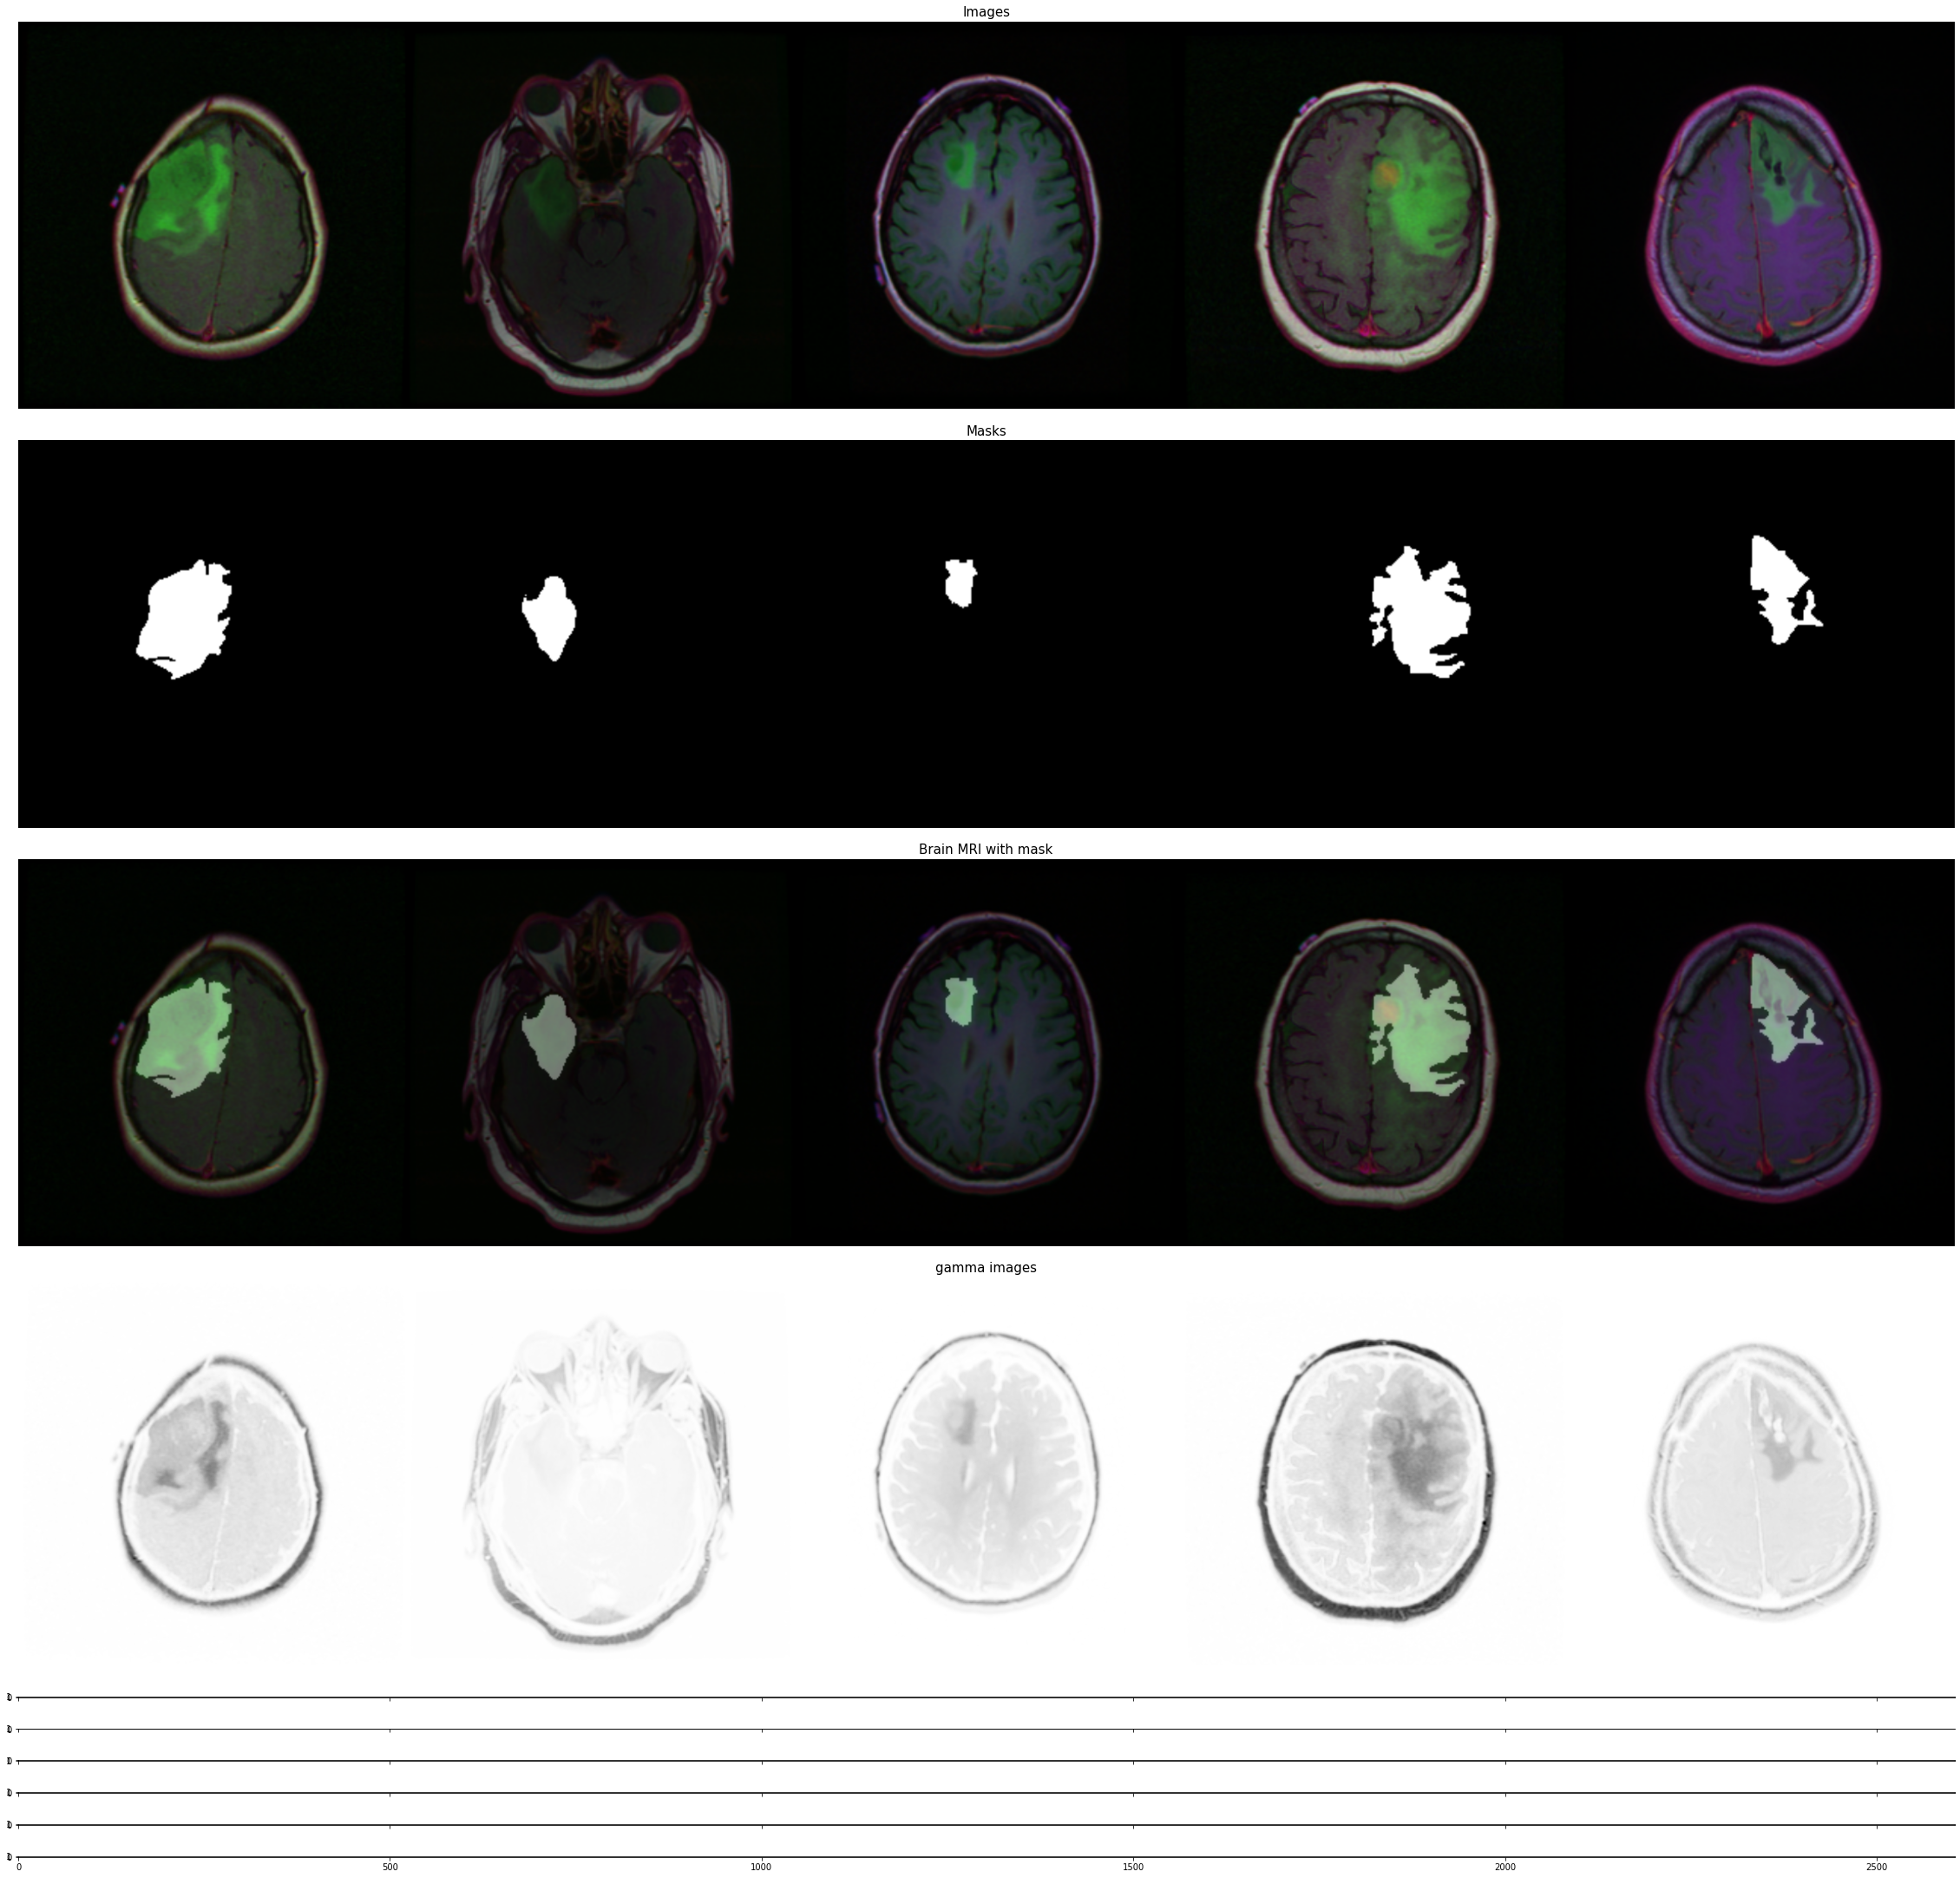

In [ ]:
fig = plt.figure(figsize=(40,40));
grid = ImageGrid(fig, 111, nrows_ncols=(10,1), axes_pad=0.5);

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')
grid[3].imshow(gamma_images[:,:,0], cmap='Greys')
grid[3].set_title('gamma images', fontsize=15)
grid[3].axis('off')
grid[4].imshow(hist_eq_images[:,:,0], cmap='Greys')
grid[4].set_title('hist eq images', fontsize=15)
grid[4].axis('off')
grid[5].imshow(gray_images[:,:,0], cmap='Greys')
grid[5].set_title('gray images', fontsize=15)
grid[5].axis('off')
grid[6].imshow(prewitt_images[:,:,0], cmap='Greys')
grid[6].set_title('prewitt edge images', fontsize=15)
grid[6].axis('off')
grid[7].imshow(prewitt_h_images[:,:,0], cmap='Greys')
grid[7].set_title('prewitt h edge images', fontsize=15)
grid[7].axis('off')
grid[8].imshow(prewitt_v_images[:,:,0], cmap='Greys')
grid[8].set_title('prewitt v edge images', fontsize=15)
grid[8].axis('off')
grid[9].imshow(local_segments_images[:,:,0], cmap='Greys')
grid[9].set_title('local threshoulding', fontsize=15)
grid[9].axis('off')

## Create dataset

In [ ]:
class BrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask

In [ ]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

In [ ]:
train_dataset = BrainDataset(train_df, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = BrainDataset(val_df, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

test_dataset = BrainDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

## Create Model

In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
    
    def forward(self, x):
        enc1 = self.encoder1(x)

        enc2 = self.encoder2(self.pool1(enc1))

        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv(dec1))
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "elu1", nn.ELU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "elu2", nn.ELU(inplace=True)),
                ]
            )
        )

In [ ]:
def dice2(y_pred, y_true, eps=1e-6):
    iflat = y_pred.view(-1)
    tflat = y_true.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + eps) / (iflat.sum() + tflat.sum() + eps))

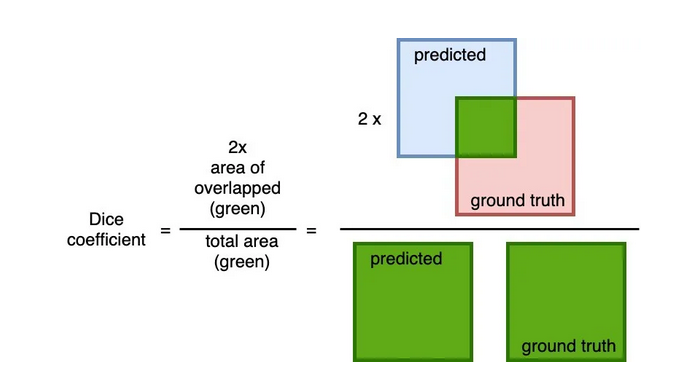

In [ ]:
def bce_dice(y_pred, y_true):
    dice_loss = dice2(y_pred, y_true)
    bce_score = nn.BCELoss()
    bce_loss = bce_score(y_pred, y_true)
    
    return (1.5* dice_loss + bce_loss)/2.5

In [ ]:
x = torch.tensor([0., 0., 0., 1., 1., 1., 0., 0.])
y = torch.tensor([0., 0., 1., 1., 1., 1., 1., 0.])
dice2(x, x), dice2(x, y)

In [ ]:
bce_dice(x, x), bce_dice(x, y)

In [ ]:
def train_model(model, optimizer, epochs, train_data_loader, valid_data_loader):
    metrics = defaultdict(list)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        metric = 0

        with tqdm(train_data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            
            for i, (images, target) in enumerate(tepoch):
                
                images = images.to(device)
                target = target.to(device) 
                
                optimizer.zero_grad()
                
                preds = model(images)
                
                loss = bce_dice(preds, target)
                
                loss.backward()
                
                optimizer.step()
                
                train_loss += loss.item()
                
                tepoch.set_postfix(loss=train_loss / (i + 1))
                
            metrics['loss'].append(train_loss / (i + 1))
            
        model.eval()
        
        with torch.no_grad():
            valid_loss = 0
            
            with tqdm(valid_data_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")

                for i, valid_batch in enumerate(tepoch):
                    valid_images, valid_target = valid_batch
                    valid_images = valid_images.to(device)
                    valid_target = valid_target.to(device)

                    valid_preds = model(valid_images)

                    loss_valid = bce_dice(valid_preds, valid_target)

                    valid_loss += loss_valid.item()

                    tepoch.set_postfix(val_loss=valid_loss / (i + 1))

                metrics['val_loss'].append(valid_loss / (i + 1))

    return model, metrics

## U-Net Architecture

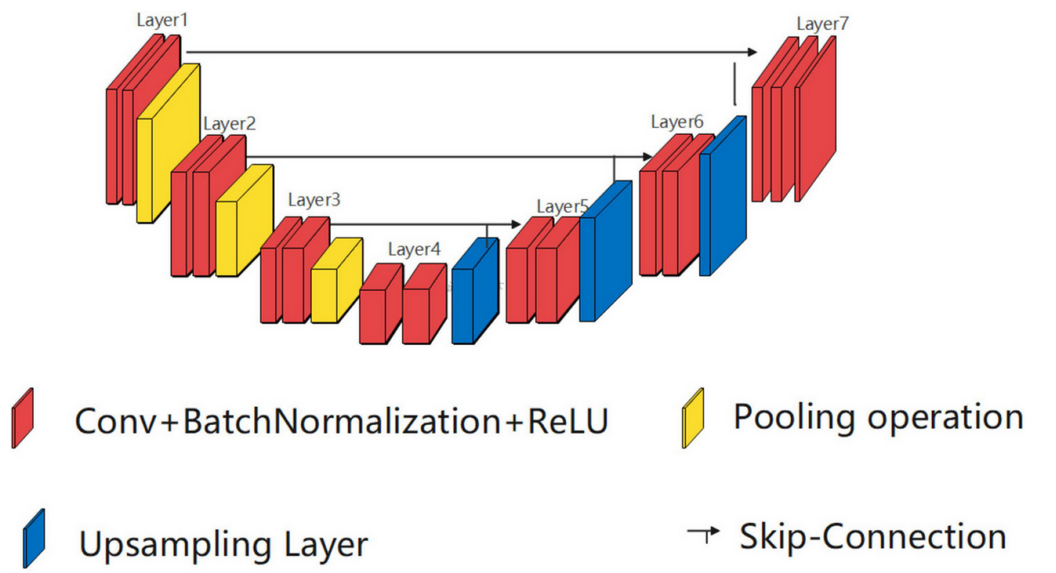

In [ ]:
! pip install torchinfo

In [ ]:
net = UNet()
modules = [module for module in net.modules()]
print(modules[0])

In [ ]:
from torchinfo import summary

model = UNet()
batch_size = 26
summary(model, input_size=(batch_size, 3, 128, 128))

In [ ]:
model = UNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 60
  
model, losses = train_model(model=model, optimizer=optimizer, epochs=epochs,
                            train_data_loader=train_dataloader, valid_data_loader=val_dataloader)

In [ ]:
def graph_plot(history):

    epoch = len(history['loss'])
    size = len(history.keys()) // 2 + 1

    ncols = 4
    nrows = int(np.ceil(size / ncols))

    fig = plt.figure(figsize=(27, 4))
    i = 1
    for k in list(history.keys()):
        if 'val' not in k:
            fig.add_subplot(nrows, ncols, i)
            plt.plot(history[k], marker='o', markersize=5)
            if k != 'lr':
                plt.plot(history['val_' + k], marker='o', markersize=5)
            plt.title(k, fontsize=10)

            plt.ylabel(k)
            plt.xlabel('epoch')
            plt.grid()

            plt.yticks(fontsize=10, rotation=30)
            plt.xticks(fontsize=10, rotation=30)
            plt.legend(['train', 'valid'], loc='upper left', fontsize=10, title_fontsize=15)
            i += 1

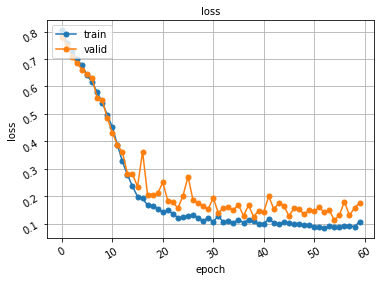

In [ ]:
graph_plot(losses)

In [ ]:
def plot_result(model, loader, ax):
    images, target = next(iter(loader))
    ind = np.random.choice(range(loader.batch_size))
    
    input_image = images[ind].view(1, 3, 128, 128).to(device)
    
    pred = model(input_image)

    loss = dice2(pred, target[ind].to(device))
    
    pred = pred.cpu().detach()[0].permute(1, 2, 0).reshape(128, 128)
    
    inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])
    
    images = inv_normalize(images)
    
    image = images[ind].permute(1, 2, 0)
    
    target = target[ind].permute(1, 2, 0).reshape(128, 128)
    target = Image.fromarray(np.asarray(target * 255, dtype=np.uint8)).convert('RGB')
    pred = Image.fromarray(np.asarray(pred * 255, dtype=np.uint8)).convert('RGB')
    
    target = np.asarray(target)
    pred = np.asarray(pred)
    
    ax.imshow(np.hstack([image, target, pred]))
    ax.set_title(f'Original Image / Target / Predict ; loss = {round(float(loss), 3)}', fontsize=14)

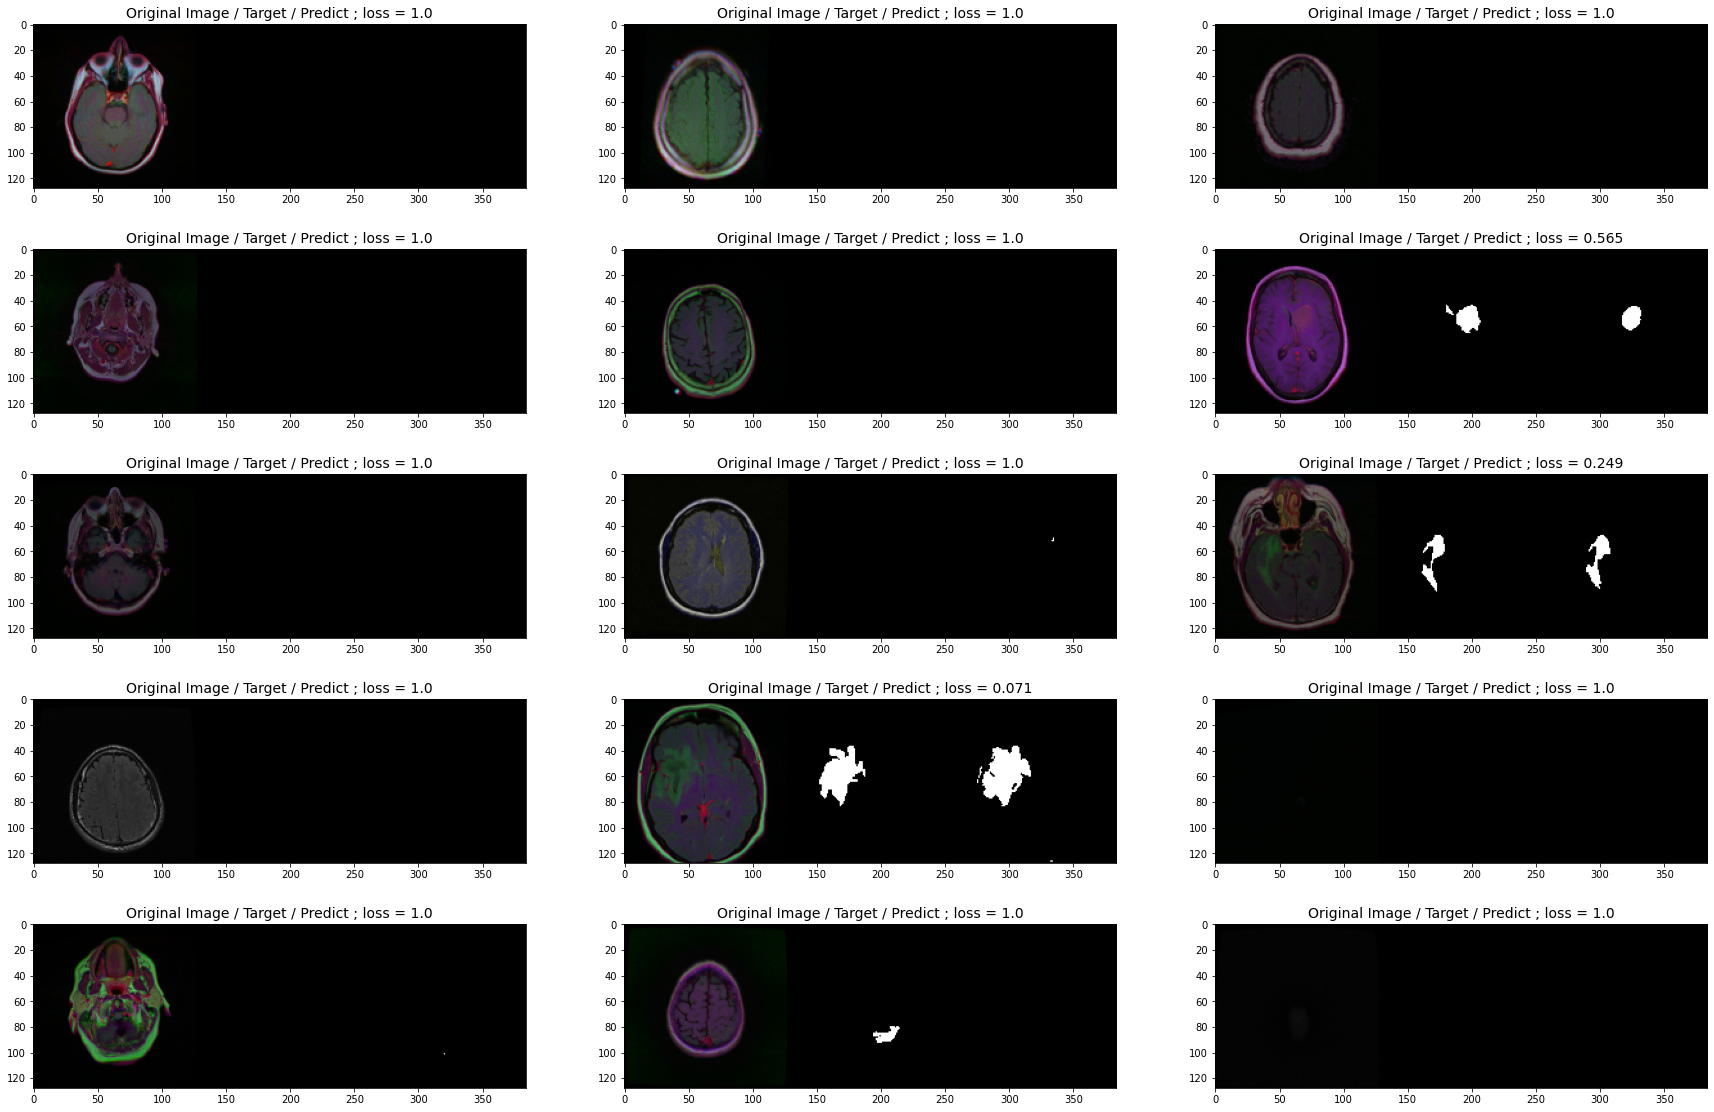

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(30, 20))

for ax in axes.flatten():
    plot_result(model=model, loader=test_dataloader, ax=ax)

In [ ]:
class BrainGrayDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)
        image = rgb2gray(image)

        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        image = np.array([image])
        image = torch.from_numpy(image).type(torch.float32)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask

In [ ]:
train_dataset = BrainGrayDataset(train_df, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = BrainGrayDataset(val_df, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

test_dataset = BrainGrayDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

In [ ]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [ ]:
model1 = UNet(in_channels=1).to(device)
model1.apply(weight_reset)

optimizer = optim.Adam(model1.parameters(), lr=0.0001)

epochs = 60
  
model1, losses1 = train_model(model=model1, optimizer=optimizer, epochs=epochs,
                            train_data_loader=train_dataloader, valid_data_loader=val_dataloader)

Epoch 60: 100%|██████████| 50/50 [00:01<00:00, 31.63batch/s, val_loss=0.167]


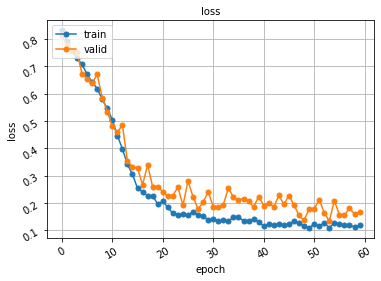

In [ ]:
graph_plot(losses1)

In [ ]:
def plot_result(model, loader):
    images, target = next(iter(loader))
    ind = np.random.choice(range(loader.batch_size))
    input_image = images[ind].view(1, 1, 128, 128).to(device)

    pred = model(input_image)
    loss = dice2(pred, target[ind].to(device))
    
    pred = pred.cpu().detach()[0].permute(1, 2, 0).reshape(128, 128)

    image = images[ind].reshape(128,128)
    image = np.asarray(image)

    target = target[ind].reshape(128,128)

    image = np.asarray(image) * 255
    target = np.asarray(target) * 255
    pred = np.asarray(pred) * 255


    fig = plt.figure(figsize=(15,15));
    grid = ImageGrid(fig, 111, nrows_ncols=(1,3), axes_pad=0.5);

    grid[0].imshow(image, cmap='Greys')
    grid[0].set_title('image', fontsize=15)
    grid[0].axis('off')

    grid[1].imshow(target, cmap='Greys')
    grid[1].set_title('target', fontsize=15)
    grid[1].axis('off')

    grid[2].imshow(pred, cmap='Greys')
    grid[2].set_title(f'pred with loss = {round(float(loss), 3)}', fontsize=15)
    grid[2].axis('off')

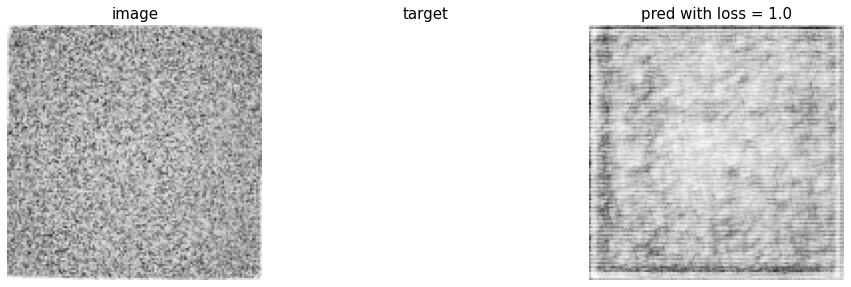

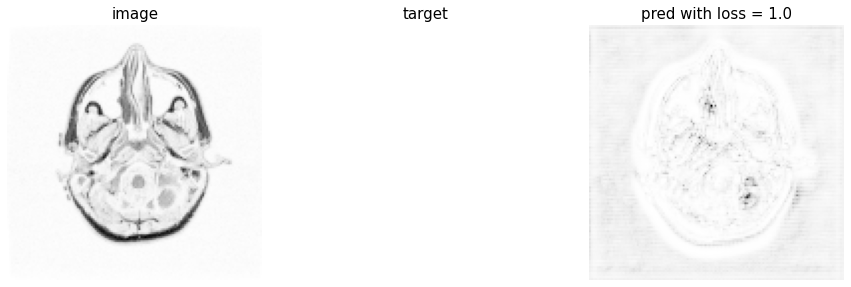

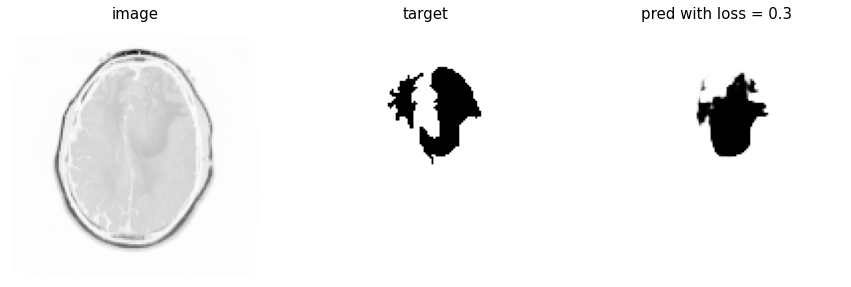

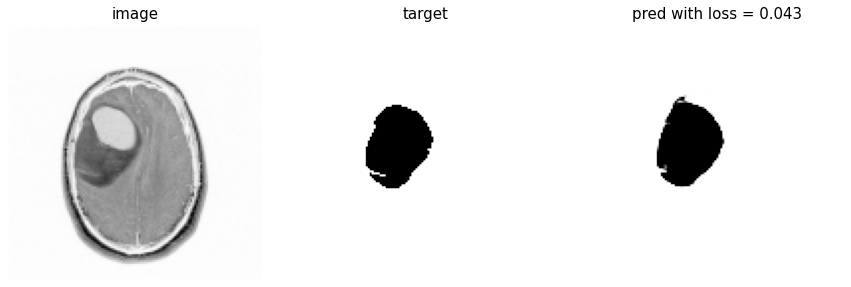

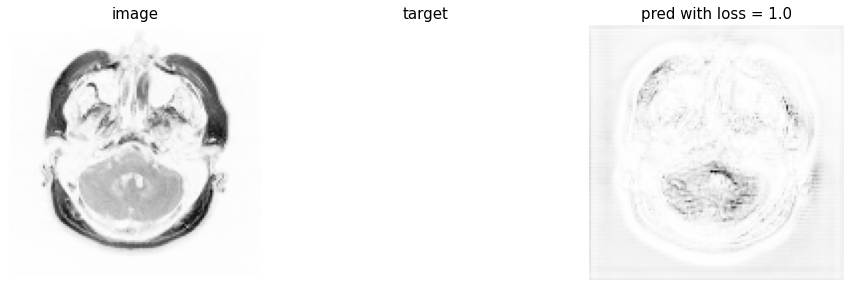

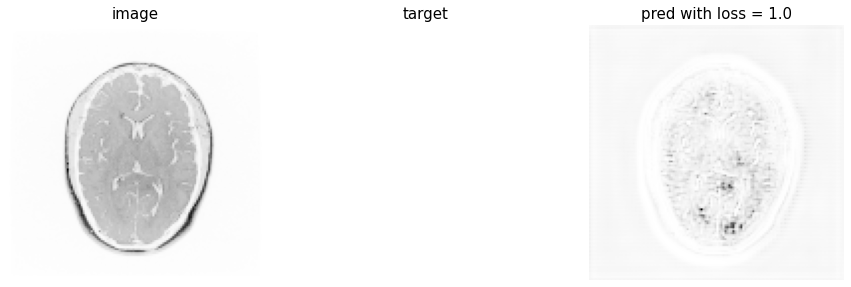

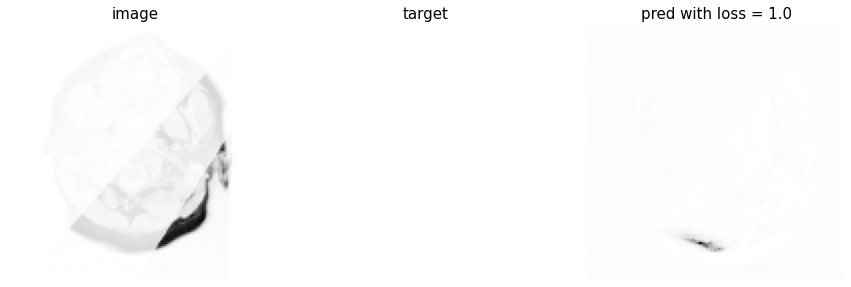

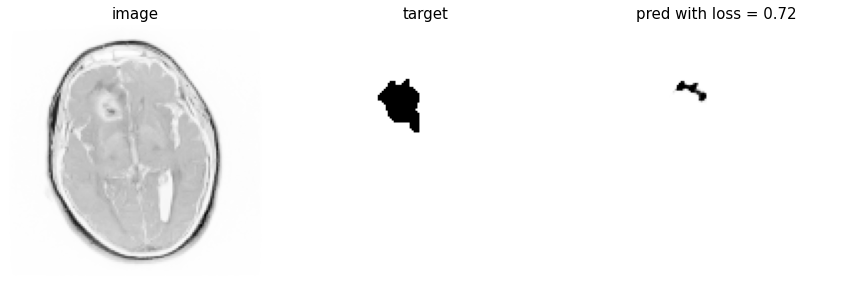

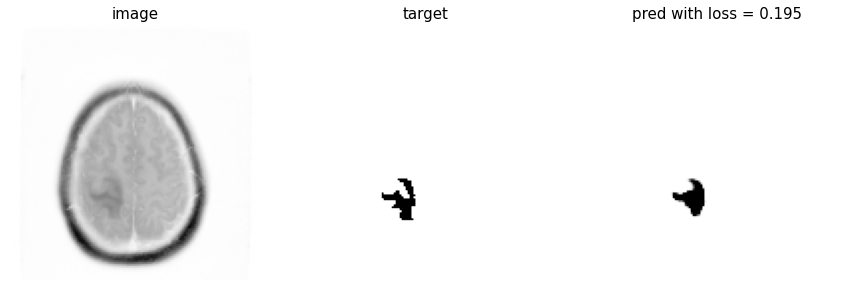

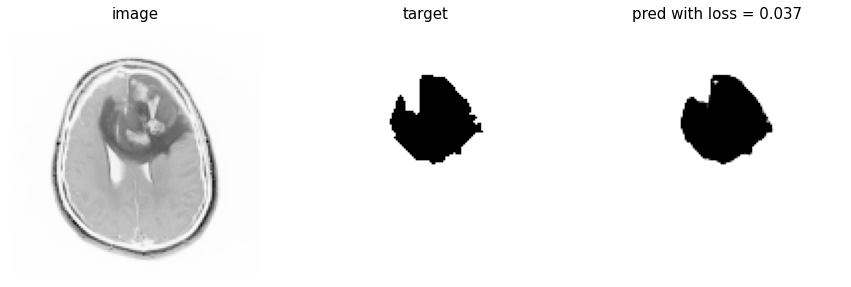

In [ ]:
for i in range(10):
    plot_result(model=model1, loader=test_dataloader)

In [ ]:
class BrainHistEqDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)
        image = rgb2gray(image)*255
        image = exposure.equalize_hist(image)

        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        image = np.array([image])
        image = torch.from_numpy(image).type(torch.float32)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask

In [ ]:
train_dataset = BrainHistEqDataset(train_df, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = BrainHistEqDataset(val_df, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

test_dataset = BrainHistEqDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

In [ ]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [ ]:
model2 = UNet(in_channels=1).to(device)
model2.apply(weight_reset)

optimizer = optim.Adam(model2.parameters(), lr=0.0001)

epochs = 60
  
model2, losses2 = train_model(model=model2, optimizer=optimizer, epochs=epochs,
                            train_data_loader=train_dataloader, valid_data_loader=val_dataloader)

Epoch 60: 100%|██████████| 50/50 [00:03<00:00, 16.45batch/s, val_loss=0.204]


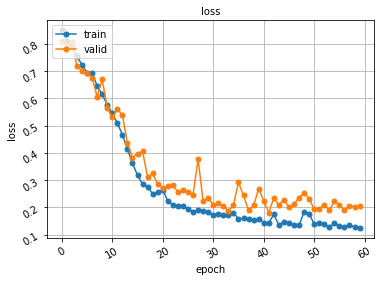

In [ ]:
graph_plot(losses2)

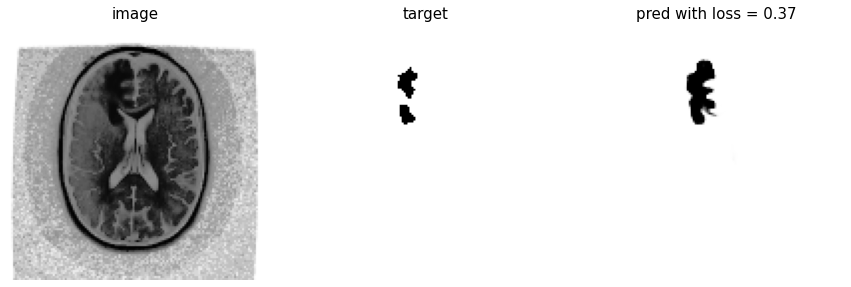

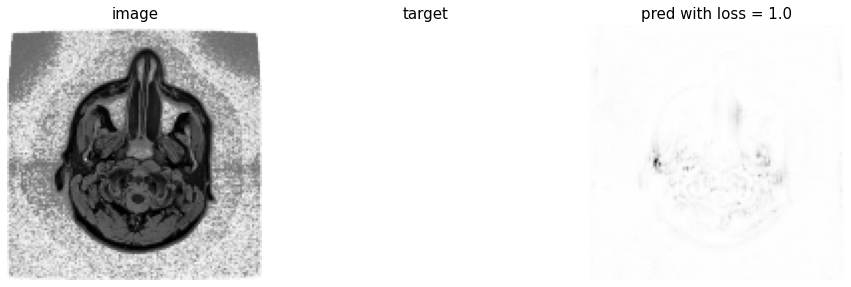

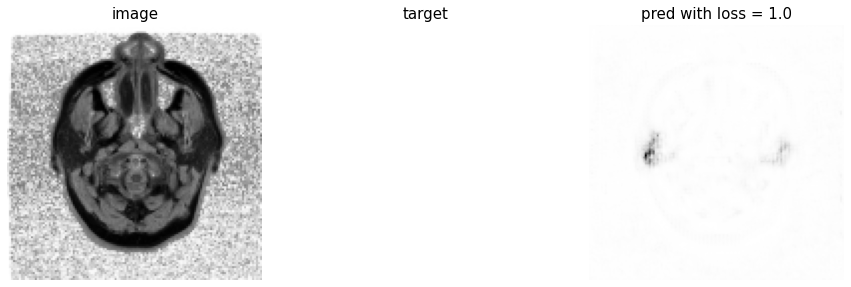

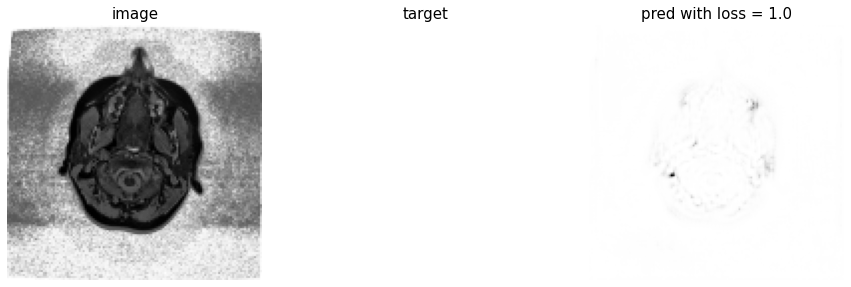

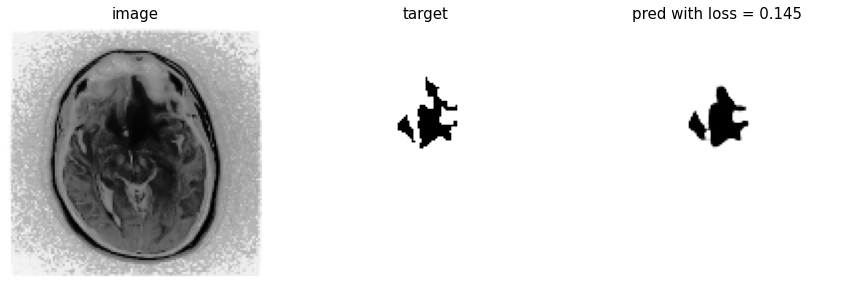

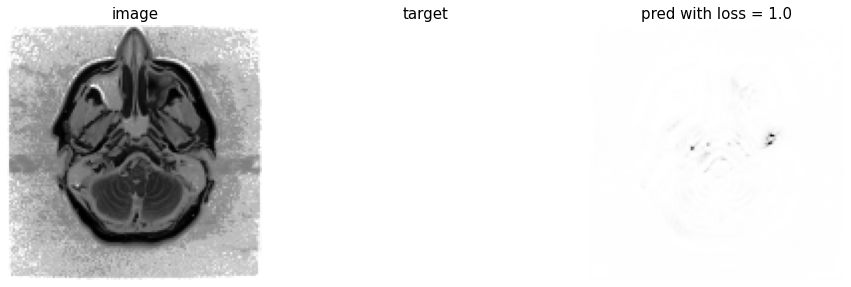

In [ ]:
for i in range(6):
    plot_result(model=model2, loader=test_dataloader)